In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF
import os 
import datetime


In [6]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_sigma_meaning/', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
    
print('Today we save all figure data in: %s '%outDir)

Today we save all figure data in: /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_sigma_meaning/2017-04-17/ 


**Executive summary** : this notebook answers a basic question 'what happens if we change the number of points or number of bootstraps in the AstroML Fig.5.8 calculation? ',  'What if we use a sinusoidal time series instead of a random set? '.... 

## 0 : Sinusoidal time series : value histogram 

Simulate a time series, sample at N equidistant points in time, plot the histogram of x : how likely are we to see a given value ?  The histogram should be the same as p(x), otherwise something is wrong ... 

| x         |  p(x) | description | 
|---------- | ----- | -------  | 
| $A \sin{t} $     |  $\frac{1}{A  \cos(\arcsin(x/A))}$     | pure sinusoid | 
| $A \sin{t} + c $ | $\frac{1}{A  \cos(\arcsin(\frac{x-c}{A}))}$ | sinusoid with constant offset | 





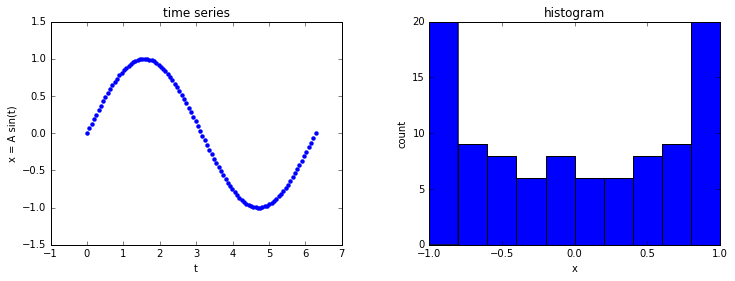

In [7]:
# pure sinusoid 
%matplotlib inline

t = np.linspace(0,2*np.pi, num=100)
A = 1 
x = A* np.sin(t)

fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('time series')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x = A sin(t)')
ax[0].scatter(t,x, lw=0)

ax[1].set_title('histogram')
ax[1].set_xlabel('x')
ax[1].set_ylabel('count')
ax[1].hist(x)

plt.savefig( outDir + 'Fig_0_sinusoid.png')

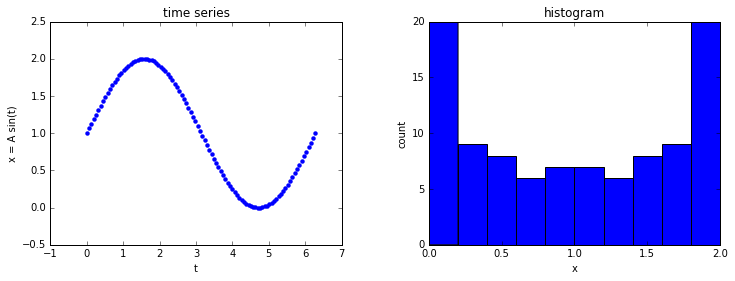

In [9]:
%matplotlib inline

t =  np.linspace(0,2*np.pi, num=100)
A = 1 
c = 1
x = A* np.sin(t) + c

fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('time series')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x = A sin(t)')
ax[0].scatter(t,x, lw=0)

ax[1].set_title('histogram')
ax[1].set_xlabel('x')
ax[1].set_ylabel('count')
ax[1].hist(x)

plt.savefig( outDir + 'Fig_0_sinusoid_and_offset.png')

The functions are different than the histograms - need to recalculate again ? Is it relevant at all  ? 


## 1: Pushing the envelope : AstroML Fig. 5.8  code ... 

The point below is to show how well we can detect variability. First we reproduce AstroML Fig. 5.8, showing that we ingest the code properly with the textbook case. Then we tweak the textbook example changing the number of points and resamples. Finally we change the functional form of the simulated time series and add Gaussian noise. 

### 1.1 : Plotting code 

In [3]:
from imp import reload
reload(varF)

<module 'variabilityFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/variabilityFunctions.py'>

In [12]:
from astroML.plotting import setup_text_plots

def plot_astroml_five_eight(plot_data, mu_true=1, sig_true=None, suptitle=None, figtitle=None, 
                            plot_mean_stdev=False, outDir = outDir): 
    # Setup plots specifics
    #setup_text_plots(fontsize=15, usetex=False)
    # Analog of Fig. 5.8
    #--------------------------------------------------
    # Plot data
    fig, ax = plt.subplots(1,3,figsize=(16, 4))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                        bottom=0.15, top=0.88)

    # first plot the histograms for mu
    #ax = fig.add_subplot(121)
    mu, sigma = plot_data['mu'], plot_data['sigma']
    p_mu, p_sigma = plot_data['p_mu'], plot_data['p_sigma']

    # plot the marginalized distribution
    ax[0].plot(mu,p_mu, '-k', label='marginalized')

    # plot the bootstrap distribution
    #bins = np.linspace(-3, 5, 14)
    ax[0].hist(plot_data['mu_boot'], histtype='step', linestyle='dashed',
            color='b', normed=True, label='approximate')

    # plot vertical line: newer matplotlib versions can use ax.vlines(x)
    #mu_true=1
    ax[0].axvline(mu_true, ls=':', color='k')
    #ax[0].axvline(np.mean(, ls=':', color='b')
    
    ax[0].set_xlabel(r'$\mu$')
    ax[0].set_ylabel(r'$p(\mu)$')
    ticks = ax[0].get_xticks()
    ax[0].set_xticks(ticks[1::2])
    #ax[0].set_xticks(ax.get_xticklabels()[::2], visible=False)
    #ax.set_ylim(0, 1.0)


    # first plot the histograms for sigma
    #ax = fig.add_subplot(122)

    # plot the marginalized distribution
    ax[1].plot(sigma, p_sigma, '-k', label='full')

    # plot the bootstrap distribution
    #bins = np.linspace(0, 5, 31)
    ax[1].hist(plot_data['sigma_boot'], histtype='step', linestyle='dashed',
            color='b', normed=True, label='approx')

    if plot_mean_stdev is True :  
        E = np.sum(p_sigma*sigma) / np.sum(p_sigma)
        stdev = np.sqrt(np.sum(sigma*sigma*p_sigma)/ np.sum(p_sigma)  - E*E)
        ax[1].axvline(E, color='green', ls='--')
        ax[1].axvline(E+stdev, color='red', ls='--')
        ax[1].axvline(E-stdev, color='red', ls='--')

    # plot vertical line: newer matplotlib versions can use ax.vlines(x)
    if sig_true is not None: 
        ax[1].axvline(sig_true, ls=':', color='k')

    ax[1].set_xlabel(r'$\sigma$')
    ax[1].set_ylabel(r'$p(\sigma)$')
    #ax[1].legend(loc=1, prop=dict(size=15))
    ticks = ax[1].get_xticks()
    ax[1].set_xticks(ticks[::2])
    #ax[1].set_xlim(0, 0.4)
    #ax[1].set_ylim(0, 1.0)
    # Analog of Fig. 5.7 
    # Print the Gaussian Distribution with Gaussian Errors  logarithm of the posterior probability density function 
    #------------------------------------------------------------
    # plot the results
    from astroML.plotting.mcmc import convert_to_stdev

    im = ax[2].imshow(plot_data['logL'], origin='lower',
               extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
               cmap=plt.cm.binary,
               aspect='auto',vmin=-5, vmax=0)
    #cbar = plt.colorbar(im , ax=ax[2])
    #

    import matplotlib as mpl
    cax,kw = mpl.colorbar.make_axes([axis for axis in ax.flat])
    cbar = plt.colorbar(im, cax=cax, **kw)
    cbar.set_label(r'$\log(L)$')

    #cbar.set_clim(-5, 0)

    #plt.text(0.5, 0.93,
    #         (r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ '
    #          r'\sigma_{\rm true}=1,\ n=10$'),
    #         bbox=dict(ec='k', fc='w', alpha=0.9),
    #         ha='center', va='center', transform=plt.gca().transAxes)

    ax[2].contour(mu, sigma, convert_to_stdev(plot_data['logL']),
                levels=(0.683, 0.955, 0.997),
                colors='k')

    ax[2].set_xlabel(r'$\mu$')
    ax[2].set_ylabel(r'$\sigma$')
    #ax[2].set_xlim(23.84, 23.96)
    #ax[2].set_ylim(0,0.12)
    ticks = ax[2].get_xticks()
    if len(ticks) > 6 : 
        ax[2].set_xticks(ticks[::2])
        
    #plt.locator_params(axis=ax[2],nbins=4)
    #ticks = ax[2].get_yticks()
    #ax[2].set_yticks(ticks[::2])
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=15)
    name = outDir+figtitle
    plt.savefig(name)
    plt.show()
    plt.close(fig)
    

### 1.2:  Reproduce verbatim   Fig 5.8  , using textbook case 

The textbook case is  

$x_{i} = \mathcal{N}(\mu = 1, \sigma = \sqrt{1 + e_{i}^{2}})$
    
where 

$e_{i} = 3 \,\mathrm{random}(0,1]$  

(achieved by $e_{i} = 3$ np.random.random($N$), where $N$ is the size of the sample) 

I experiment with the size of sample (from original $N$ of 10 to 1000 points), and with the number of bootstrap resamples (varying between original 10000 and 1000 to make calculation quicker). 

In practical application to lightcurves in S82, the sample size will correspond to the length of a ilghtcurve, whitch is between 50 and 180 points. It is not clear how many bootstrap resamples are needed, but if we only use the resamples of the approximate  method to estimate the bounds over which to evaluate the full method, it would be fine either way.  Otherwise one would naturally worry about the artificial pile-up of approximate method close to 0.  

N=10, Nboot=1000


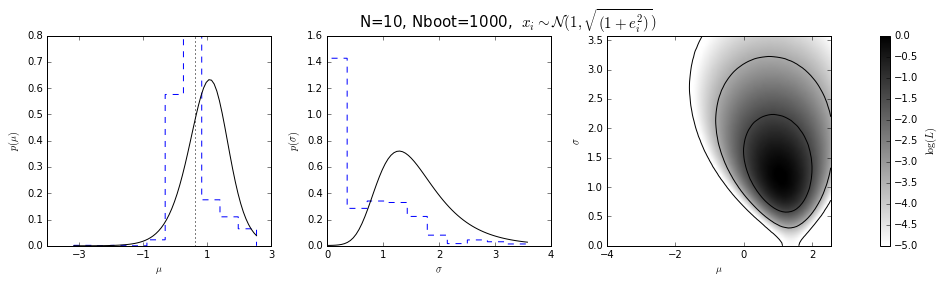

In [16]:
# Investigate N=1000,  Nboot=1000 case 

N=10
Nboot=1000

np.random.seed(5)
ei = 3 * np.random.random(N)
xi = np.random.normal(1 , np.sqrt(1+ei**2.0))
print('N=%d, Nboot=%d'%(N,Nboot))
plot_data, mu_flux, sigma_flux = varF.get_mu_sigma(xi,ei,  N_boot=Nboot, return_plot_data=True)
import gc ; gc.collect()
suptitle = 'N='+str(N)+', Nboot='+str(Nboot) +',  '+ r'$x_{i} \sim \mathcal{N}(1,\sqrt{(1+e_{i}^{2})})$'
figtitle = 'Fig_1_textbook_case_N-'+str(N)+'_N_boot-'+str(Nboot)+'.png'
plot_astroml_five_eight(plot_data , mu_true=np.mean(xi), suptitle=suptitle,
                        figtitle = figtitle)




We can treat the simulated points as a time series :
    
$t = (0,2 \pi)$  ( N uniformly spaced points) 

and 

$x_{i} = \mathcal{N}(\mu = 1, \sigma = \sqrt{1 + e_{i}^{2}})$
    
where 

$e_{i} = 3 \,\mathrm{random}(0,1]$  


Although , to be strictly speaking, the points are purely randomly chosen - time is not a dependant variable here.  It should be thought of more that instead of plotting  $x_{i}$ against the position of that number in the array, I make a mapping from that position to a uniformly spaced time array $t_{i}$, so that each $x_{i}$ corresponds to some $t_{i}$. Because it is random, it doesn't matter if I completely reshuffle $t_{i}$. 

The sole purpose of even calling the position along the array '$t_{i}$' is to make a comparison to an actual time-series (A sin(t)) more straightforward.

N=10, Nboot=1000


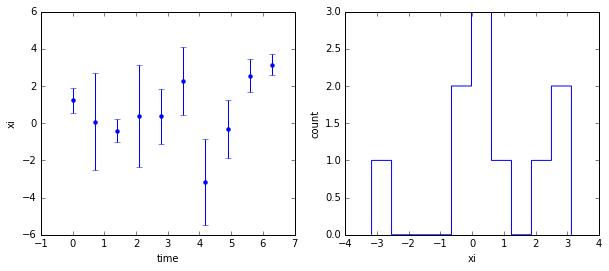

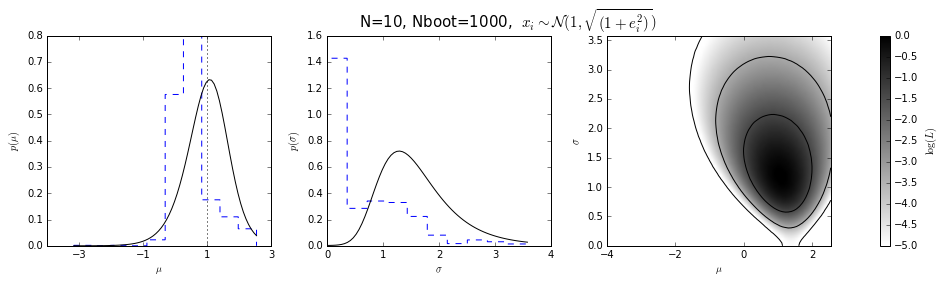

N=10, Nboot=10000


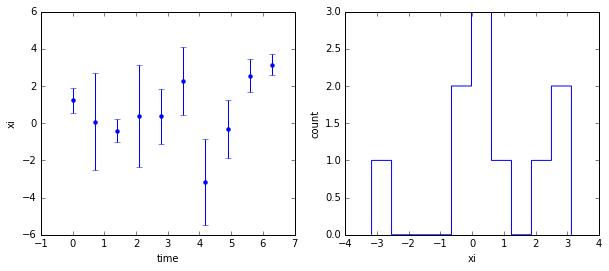

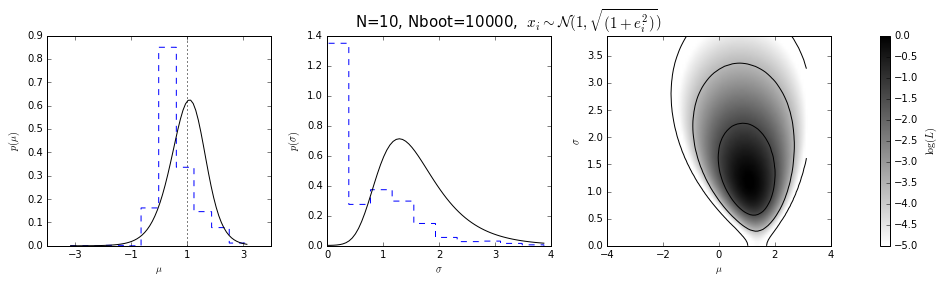

N=100, Nboot=1000


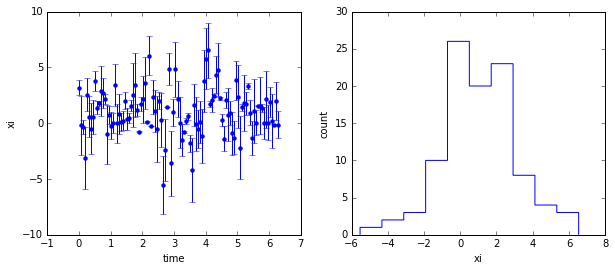

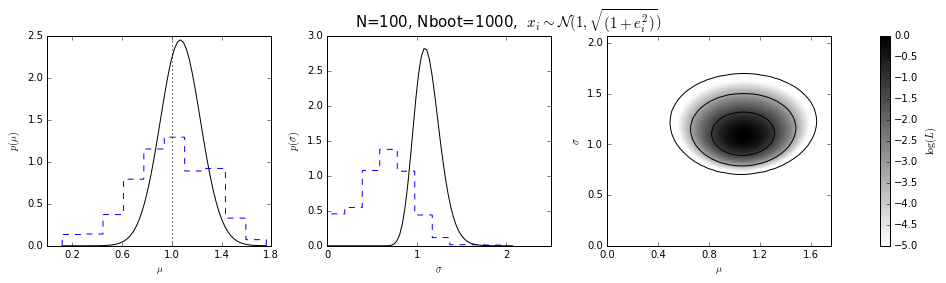

N=100, Nboot=10000


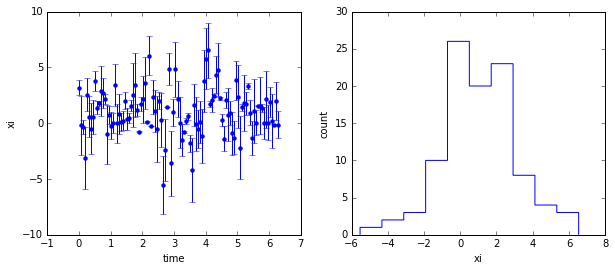

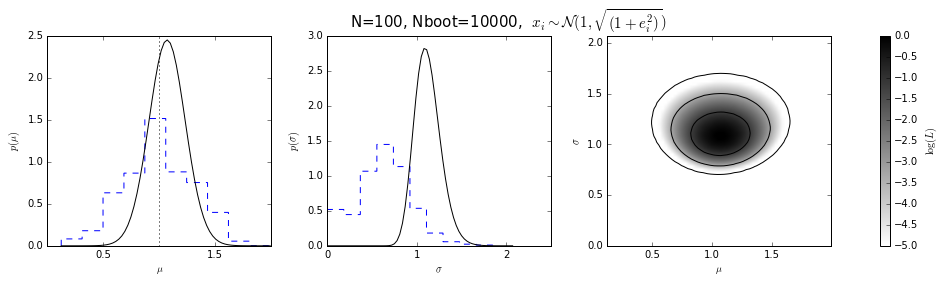

N=1000, Nboot=1000


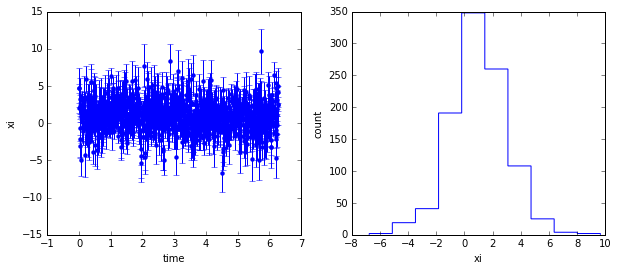

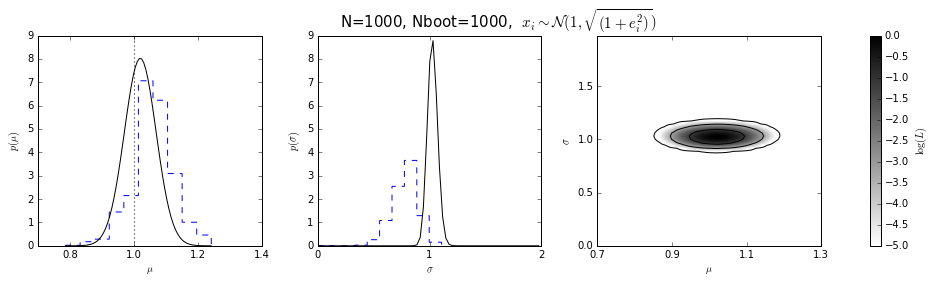

N=1000, Nboot=10000


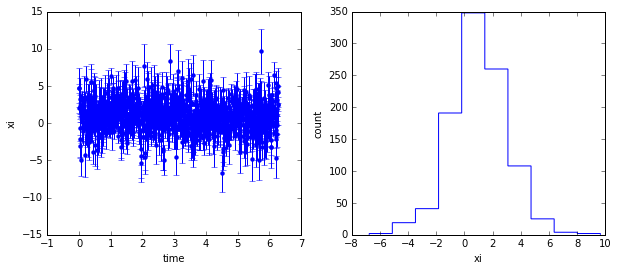

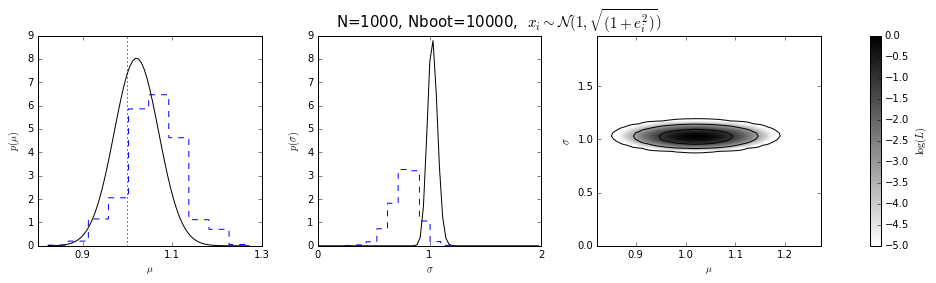

In [23]:
import gc ; gc.collect()

import matplotlib.pyplot as plt 
np.random.seed(5)

i = 0
for N in [10,100,1000]:
    for Nboot in [1000,10000]:
        
        np.random.seed(5)
        t = np.linspace(0,2*np.pi, num=N)
        ei = 3 * np.random.random(N)
        xi = np.random.normal(1 , np.sqrt(1+ei**2.0))
        
        # make a figure of the time series 
        fig,ax = plt.subplots(1,2, figsize=(10,4))
        label = r'$ x_{i} \sim \mathcal{N}(1,\sqrt{(1+e_{i}^{2})})$'
        
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('xi')
        ax[0].scatter(t,xi,lw=0)
        ax[0].errorbar(t,xi,ei, ls='')
        
        ax[1].set_xlabel('xi')
        ax[1].set_ylabel('count')
        ax[1].hist(xi,histtype='step')

        plt.savefig(outDir+'Fig_1_textbook_N-'+str(N)+'.png')
    
        print('N=%d, Nboot=%d'%(N,Nboot))
        plot_data, mu_flux, sigma_flux = varF.get_mu_sigma(xi,ei,  N_boot=Nboot, return_plot_data=True)
        
        # set the suptitle for figure and filename 
        suptitle = 'N='+str(N)+', Nboot='+str(Nboot) +',  '+ r'$x_{i} \sim \mathcal{N}(1,\sqrt{(1+e_{i}^{2})})$'
        figtitle = 'Fig_1_textbook_N-'+str(N)+'_N_boot-'+str(Nboot)+'.png'
        plot_astroml_five_eight(plot_data ,  suptitle=suptitle, figtitle = figtitle)
        i += 1 




## 2 : AstroML 5.8 code on sinusoidal time series

Here we use the same code as above, but given our knowledge of the input variability for the sinusoidal time series 

$x = A sin(t) + \mathcal{N}(0,\sigma)+1$

$e = 1$ (we assume homoscedastic errors.  A 'value'  of each point is  the result of harmonic time series with added mean and Gaussian noise with a width of $\sigma$, so  $\sigma$ here stands for the noisyness of data. 

we want to find out whether we correctly recover the underlying variance. 

This code is vastly improved in 

    Variability_time_completeness_curve.ipynb 
    
notebook. 

Amin = 1.897367
mean of xi=0.794528
sigma=2.000000


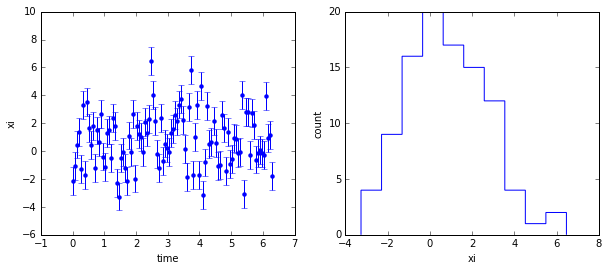

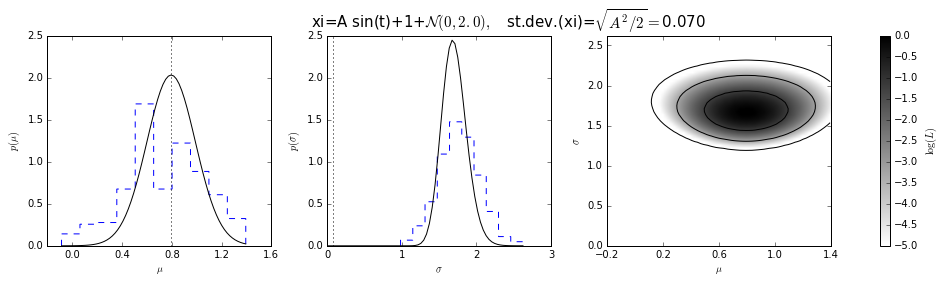

In [31]:
%matplotlib inline

N = 100
Nboot = 1000

t = np.linspace(0,2*np.pi, num=N)
A = 0.1
sigma = [2.0] # [0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 0.3, 0.5, 1]
error = 1.0

 # that is 0.1%,  0.5%, 1%, 2%, 3%, 5% 

i = 0
for sig in sigma:
    
    noise = np.random.normal(loc=0.0, scale=sig, size=len(t)) 
    xi = A* np.sin(t) + 1 + noise
    ei = np.ones_like(xi) * error 
    # make a figure of the time series 
    fig,ax = plt.subplots(1,2, figsize=(10,4))

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('xi')
    ax[0].scatter(t,xi,lw=0)
    ax[0].errorbar(t,xi,ei, ls='')

    ax[1].set_xlabel('xi')
    ax[1].set_ylabel('count')
    ax[1].hist(xi,histtype='step')

    plt.savefig(outDir+'Fig_1_sinusoid_N-'+str(N)+'.png')
    
    print('Amin = %f'%(3*sig / N**(0.25)))
    print('mean of xi=%f'%np.mean(xi))
    print('sigma=%f'%sig)
    
    # do it in flux space ... 
    plot_data, mu_flux, sigma_flux = varF.get_mu_sigma(xi,ei, N_boot=Nboot, return_plot_data=True)
    import gc ; gc.collect()
    sig_exp = np.sqrt(A*A / 2.0 )
    sup = 'xi=A sin(t)+1+'+r'$\mathcal{N}(0,'+str(sig)+'),$   ' + 'st.dev.(xi)='+r'$\sqrt{A^{2}/2}=$'+str(sig_exp)[:5]
    figt = 'Fig_1_sinusoid_N-'+str(N)+'_Nboot-'+str(Nboot)+'_sigma-'+str(sig)+'.png'
    plot_astroml_five_eight(plot_data , mu_true=np.mean(xi), sig_true=A/np.sqrt(2), 
                            suptitle=sup, figtitle = figt)
    i += 1 

mean of xi=0.989325
sigma=0.100000


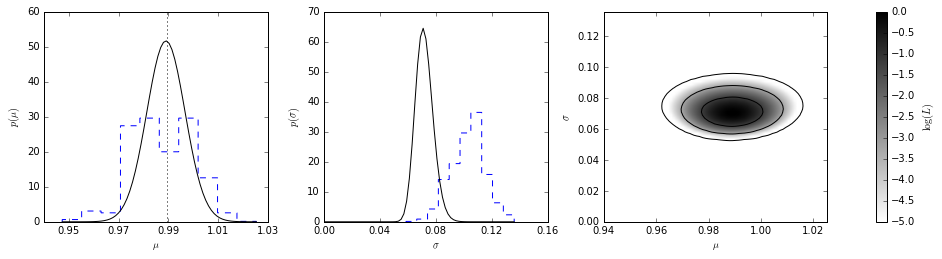

(array([  1.,   0.,   3.,   4.,   6.,  13.,  17.,  17.,  15.,  24.,  14.,
         11.,  10.,   5.,   5.,   1.,   1.,   1.,   1.,   1.]),
 array([ 0.67164198,  0.70715976,  0.74267754,  0.77819531,  0.81371309,
         0.84923087,  0.88474865,  0.92026642,  0.9557842 ,  0.99130198,
         1.02681976,  1.06233753,  1.09785531,  1.13337309,  1.16889087,
         1.20440864,  1.23992642,  1.2754442 ,  1.31096197,  1.34647975,
         1.38199753]),
 <a list of 1 Patch objects>)

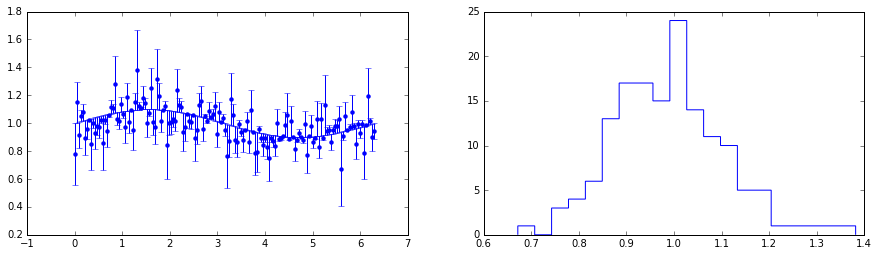

In [14]:

# Plot also histogram of xi values to see how the width of the distribution originates solely from the amplitude 
# of sinusoidal oscillation, but it gets broader as the error increases, i.e. it is harder to see that there 
# is any underlying variability if the error  becomes too large 

%matplotlib inline

N = 100
Nboot = 1000

t = np.linspace(0,2*np.pi, num=150)
A = 0.1
sigma = [0.001, 0.005, 0.01, 0.02, 0.1, 0.2, 0.3, 0.5]
 # that is 0.1%,  0.5%, 1%, 2%, 3%, 5% 
    
sig=0.1
ei = np.random.normal(loc=0.0, scale=sig, size=len(t))
xi = A* np.sin(t) + 1 + ei
print('mean of xi=%f'%np.mean(xi))
print('sigma=%f'%sig)
# do it in flux space ... 
plot_data, mu_flux, sigma_flux = varF.get_mu_sigma(xi,ei, N_boot=Nboot, return_plot_data=True)
import gc ; gc.collect()
plot_astroml_five_eight(plot_data , mu_true=np.mean(xi),figtitle = 'Fig_5.8_sin_N-'+str(N)+'_N_boot-'+str(Nboot)+'.png')

fig,ax = plt.subplots(1,2, figsize=(15,4))
ax[0].scatter(t,xi,lw=0)
ax[0].errorbar(t,xi,ei,ls='')
ax[1].hist(xi, histtype='step', bins=20)